In [ ]:
#%pip install "numpy<2.0" scikit-learn tensorflow adversarial-robustness-toolbox --force-reinstall
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from art.estimators.classification import SklearnClassifier, TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent
from art.defences.trainer import AdversarialTrainer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix

In [78]:
df = pd.read_csv("SQLiV3.csv")
print(df.columns)

Index(['Sentence', 'Label', 'Unnamed: 2', 'Unnamed: 3'], dtype='object')


In [79]:
df = df.drop(columns=['Unnamed: 2', 'Unnamed: 3'], errors='ignore')
df = df[df['Label'].isin(['0', '1'])]
df = df[['Sentence', 'Label']].dropna()

df = df.reset_index(drop=True)

df.head()

,Sentence,Label
0,""" or pg_sleep ( __TIME__ ) --",1
1,AND 1 = utl_inaddr.get_host_address ( ...,1
2,select * from users where id = '1' or @ @1 ...,1
3,"select * from users where id = 1 or 1#"" ( ...",1
4,select name from syscolumns where id = ...,1


In [87]:
custom_feature_names = [
    "length",
    "num_quotes",
    "num_equals",
    "num_semicolons",
    "num_keywords",
    "has_comment",
    "has_union",
    "has_sleep",
    "num_digits"
]

def extract_features(sentence):
    return {
        "length": len(sentence),
        "num_quotes": sentence.count("'") + sentence.count('"'),
        "num_equals": sentence.count("="),
        "num_semicolons": sentence.count(";"),
        "num_keywords": len(re.findall(r"\b(select|union|insert|drop|update|or|and|where|sleep|benchmark)\b", sentence, re.IGNORECASE)),
        "has_comment": int("--" in sentence or "/*" in sentence),
        "has_union": int("union" in sentence.lower()),
        "has_sleep": int("sleep" in sentence.lower()),
        "num_digits": sum(c.isdigit() for c in sentence),
    }

X_custom = df['Sentence'].apply(extract_features)
X_custom_df = pd.DataFrame(X_custom.tolist())

# Combine the features
scaler = StandardScaler()
X_custom_scaled = scaler.fit_transform(X_custom_df)

# Labels
y = df['Label']
y = y.to_numpy()

# Recreate the DataFrame with custom features
X_custom_df = pd.DataFrame(X_custom_scaled, columns=custom_feature_names)
df = pd.concat([X_custom_df, df['Label']], axis=1)
df.head()

,length,num_quotes,num_equals,num_semicolons,num_keywords,has_comment,has_union,has_sleep,num_digits,Label
0,-0.444534,-0.053037,-0.690799,-0.090599,-0.380841,2.590756,-0.316313,5.084290,-0.600525,1
1,1.827885,1.071984,2.885971,-0.090599,2.479637,-0.385988,-0.316313,-0.196684,-0.451514,1
2,0.255617,1.071984,1.693714,-0.090599,2.479637,2.590756,3.161426,-0.196684,-0.227998,1
3,0.194200,-0.053037,0.501457,-0.090599,2.479637,2.590756,3.161426,-0.196684,-0.302503,1
4,0.489001,-0.053037,1.693714,-0.090599,1.764518,2.590756,-0.316313,-0.196684,-0.600525,1


In [88]:
df.describe()

,length,num_quotes,num_equals,num_semicolons,num_keywords,has_comment,has_union,has_sleep,num_digits
count,3.060900e+04,3.060900e+04,3.060900e+04,3.060900e+04,3.060900e+04,3.060900e+04,30609.000000,3.060900e+04,3.060900e+04
mean,-6.685495e-17,-2.971331e-17,5.942662e-17,7.428327e-18,8.913993e-17,7.428327e-17,0.000000,-7.428327e-18,-5.942662e-17
std,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016e+00,1.000016,1.000016e+00,1.000016e+00
min,-8.376005e-01,-6.155475e-01,-6.907991e-01,-9.059918e-02,-1.095961e+00,-3.859877e-01,-0.316313,-1.966843e-01,-6.005252e-01
25%,-6.042170e-01,-6.155475e-01,-6.907991e-01,-9.059918e-02,-1.095961e+00,-3.859877e-01,-0.316313,-1.966843e-01,-6.005252e-01
50%,-2.602834e-01,-6.155475e-01,-6.907991e-01,-9.059918e-02,-3.808411e-01,-3.859877e-01,-0.316313,-1.966843e-01,-4.515142e-01
75%,1.450670e-01,5.094738e-01,5.014574e-01,-9.059918e-02,3.342785e-01,-3.859877e-01,-0.316313,-1.966843e-01,1.445298e-01
max,6.511167e+01,1.063467e+01,3.150013e+01,9.306432e+01,7.485474e+00,2.590756e+00,3.161426,5.084290e+00,4.715750e+01


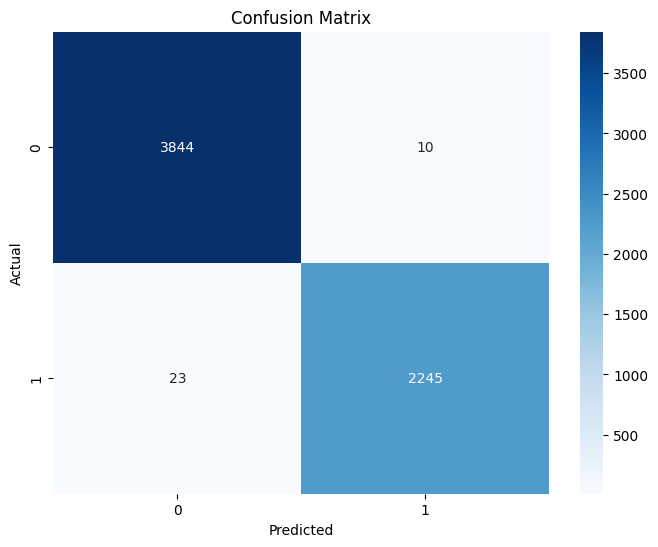

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_custom_scaled, y, stratify=y, test_size=0.2, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

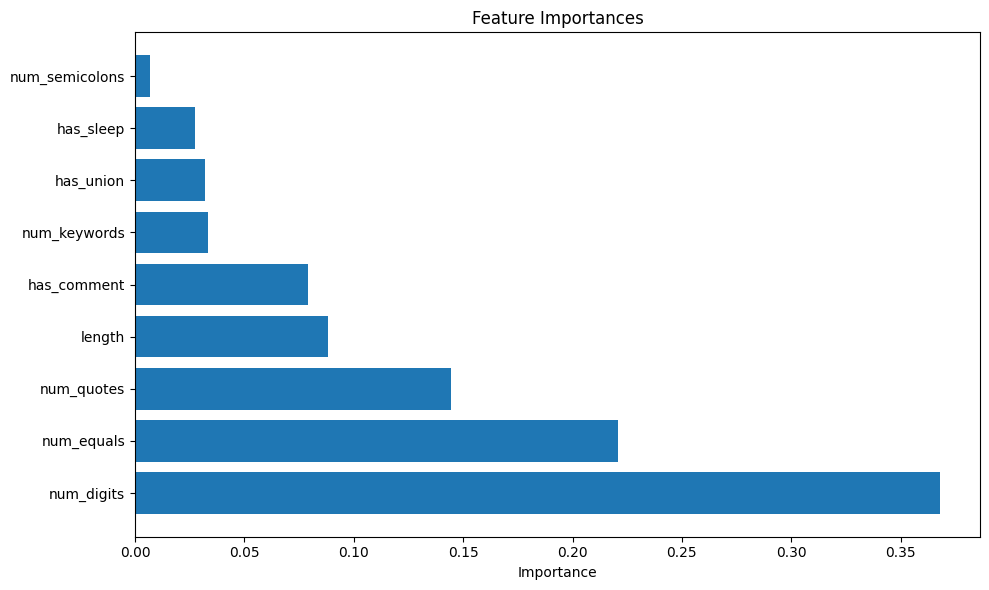

In [82]:
importances = clf.feature_importances_
feature_names = custom_feature_names

# Sort features by importance
indices = importances.argsort()[::-1]
importances = importances[indices]
feature_names = [feature_names[i] for i in indices]

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


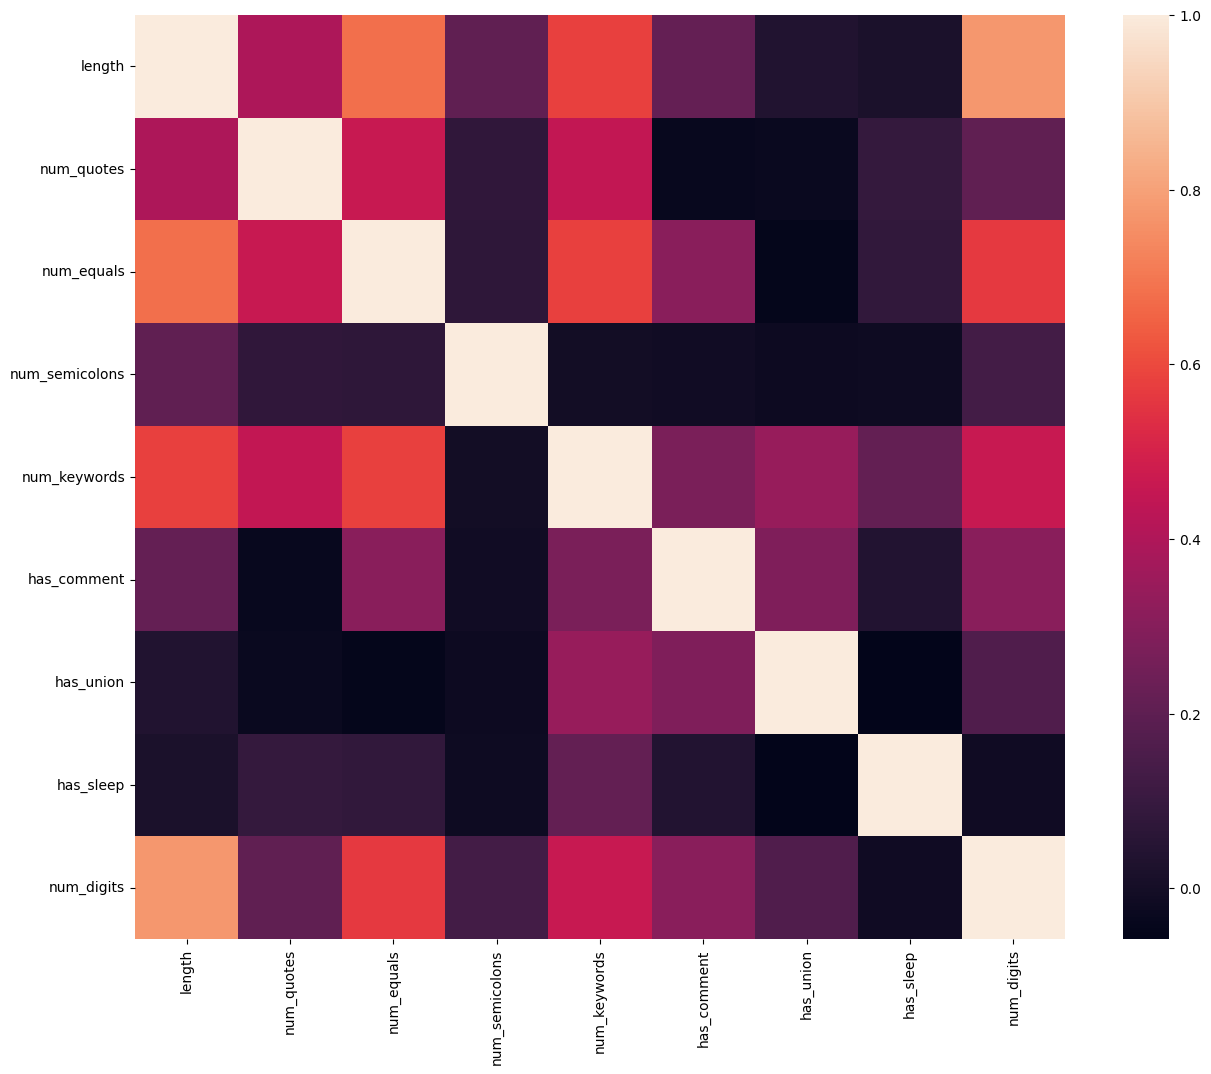

In [83]:
# Calcul de la matrice de corrélation
corr = pd.DataFrame(X_custom_scaled, columns=custom_feature_names).corr()

plt.figure(figsize =(15, 12))
sns.heatmap(corr)
plt.show()

Accuracy: 0.91


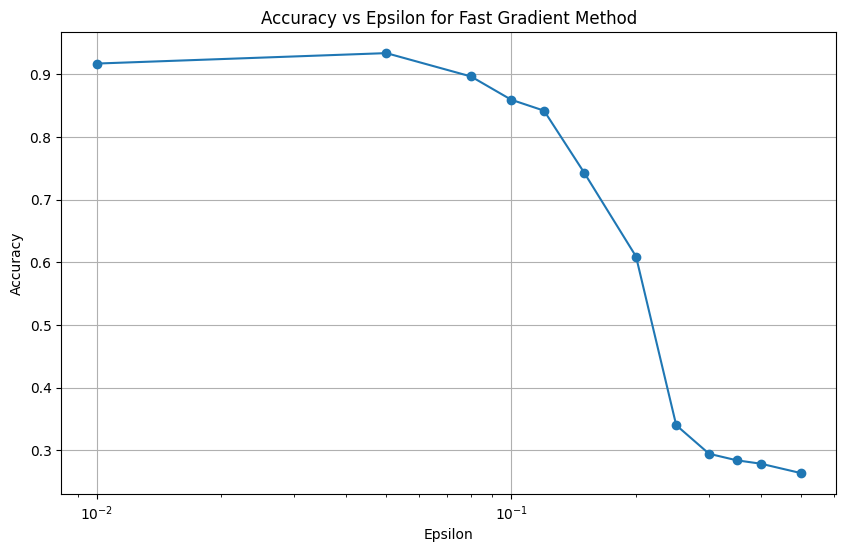

In [84]:
epsilons = [0.01, 0.05, 0.08, 0.1, 0.12, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]

# Entraîner le modèle
model = LogisticRegression(max_iter=500)
model.fit(X_train, y_train)

# Évaluer le modèle
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

accuracies = []

for epsilon in epsilons:
    # Créer l'estimateur ART
    classifier = SklearnClassifier(model=model)
    # Créer l'attaque
    attack = FastGradientMethod(estimator=classifier, eps=epsilon)
    # Générer les exemples adverses
    X_test_adv = attack.generate(x=X_test)
    # Évaluer le modèle sur les exemples adverses
    y_pred_adv = classifier.predict(X_test_adv)
    y_pred_adv_classes = np.argmax(y_pred_adv, axis=1)
    # Calculer l'accuracy sur les exemples adverses
    accuracy_adv = accuracy_score(y_test.astype(int), y_pred_adv_classes)
    accuracies.append(accuracy_adv)
    
# Afficher les résultats
plt.figure(figsize=(10, 6))
plt.plot(epsilons, accuracies, marker='o')
plt.title('Accuracy vs Epsilon for Fast Gradient Method')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.xscale('log')
plt.grid(True)
plt.show()

Epoch 1/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9400 - loss: 0.1890 - val_accuracy: 0.9782 - val_loss: 0.1157
Epoch 2/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9841 - loss: 0.0616 - val_accuracy: 0.9859 - val_loss: 0.0768
Epoch 3/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - accuracy: 0.9891 - loss: 0.0454 - val_accuracy: 0.9890 - val_loss: 0.0652
Epoch 4/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - accuracy: 0.9896 - loss: 0.0425 - val_accuracy: 0.9878 - val_loss: 0.0531
Epoch 5/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - accuracy: 0.9888 - loss: 0.0452 - val_accuracy: 0.9898 - val_loss: 0.0521
Epoch 6/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - accuracy: 0.9901 - loss: 0.0396 - val_accuracy: 0.9906 - val_loss: 0.0426
Epoch 7/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - accuracy: 0.9915 - loss: 0.0342 - val_accuracy: 0.9904 - val_loss: 0.0459
Epoch 8/10
613/613 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.9926 - loss: 0.0303 - val_

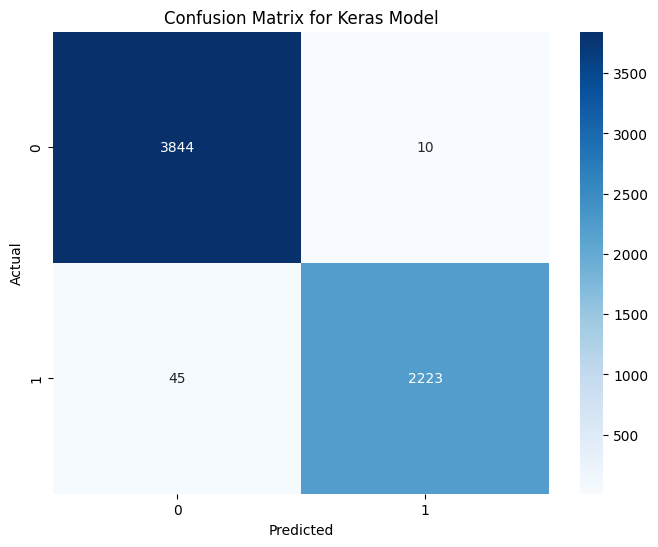

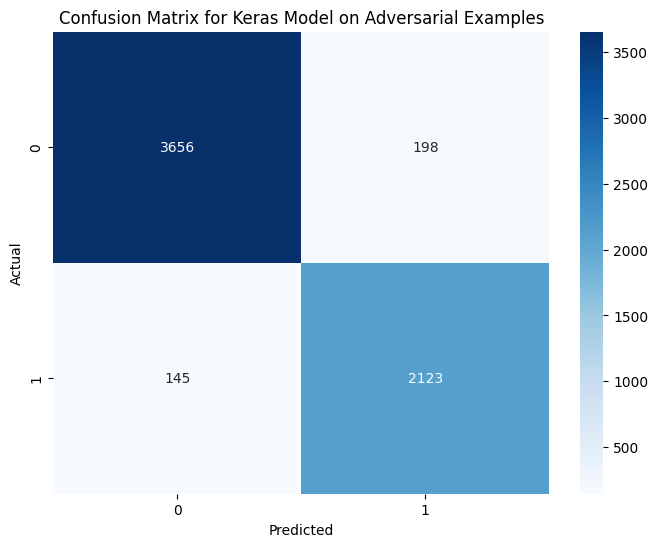

In [85]:
input_shape = (X_train.shape[1],)
num_classes = len(np.unique(y_train))

def create_keras_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Créer le modèle Keras
model_keras = create_keras_model(input_shape, num_classes)
# Entraîner le modèle Keras
model_keras.fit(X_train, y_train.astype(int), epochs=10, batch_size=32, validation_split=0.2)
# Créer l'estimateur ART pour le modèle Keras
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
classifier_keras = TensorFlowV2Classifier(model=model_keras, input_shape=input_shape, nb_classes=num_classes, loss_object=tf.keras.losses.SparseCategoricalCrossentropy(), optimizer=optimizer)
# Créer l'attaque Fast Gradient Method pour le modèle Keras
attack_keras = FastGradientMethod(estimator=classifier_keras, eps=0.1)
# Générer les exemples adverses
X_test_adv_keras = attack_keras.generate(x=X_test)
# Évaluer le modèle Keras sur les exemples adverses
y_pred_adv_keras = classifier_keras.predict(X_test_adv_keras)
y_pred_adv_classes_keras = np.argmax(y_pred_adv_keras, axis=1)
# Calculer l'accuracy sur les exemples adverses
accuracy_adv_keras = accuracy_score(y_test.astype(int), y_pred_adv_classes_keras)

y_pred_keras = model_keras.predict(X_test)
accuracy = accuracy_score(y_test.astype(int), np.argmax(y_pred_keras, axis=1))

print(f"Normal accuracy: {accuracy:.2f}")
print(f"Accuracy on adversarial examples (Keras model): {accuracy_adv_keras:.2f}")

# Display the confusion matrix for the Keras model
cm_keras = confusion_matrix(y_test.astype(int), np.argmax(y_pred_keras, axis=1))
plt.figure(figsize=(8, 6))
sns.heatmap(cm_keras, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Keras Model')
plt.show()

cm_keras_adv = confusion_matrix(y_test.astype(int), y_pred_adv_classes_keras)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_keras_adv, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Keras Model on Adversarial Examples')
plt.show()

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on adversarial examples after adversarial training: 0.99


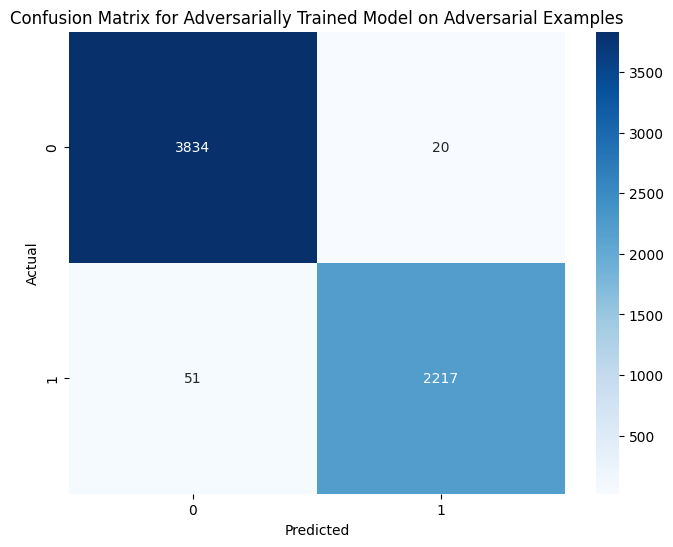

In [86]:
# Building the Adversarial Trainer
adversarial_trainer = AdversarialTrainer(
    classifier=classifier_keras,
    attacks=FastGradientMethod(classifier_keras, eps=0.1),
    ratio=0.5
)

# Training the model with adversarial examples
adversarial_trainer.fit(X_train, y_train, nb_epochs=10, batch_size=32, validation_split=0.2)
# Evaluate the adversarially trained model
y_pred_adv_trained = adversarial_trainer.classifier.predict(X_test_adv_keras)
y_pred_adv_classes_trained = np.argmax(y_pred_adv_trained, axis=1)
# Calculate accuracy on adversarial examples after adversarial training
accuracy_adv_trained = accuracy_score(y_test.astype(int), y_pred_adv_classes_trained)
print(f"Accuracy on adversarial examples after adversarial training: {accuracy_adv_trained:.2f}")
# Display the confusion matrix for the adversarially trained model
cm_adv_trained = confusion_matrix(y_test.astype(int), y_pred_adv_classes_trained)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_adv_trained, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Adversarially Trained Model on Adversarial Examples')
plt.show()